<a href="https://colab.research.google.com/github/ChelseaYYu/Seattle-Airbnb-Price-Prediction/blob/main/Airbnb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chelseayu","key":"435db44f8a1dc75ae0edd4f41784d4a7"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                                 title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           2000        194  1.0              
thedevastator/netflix-imdb-scores                                   Netflix IMDB Scores                         699KB  2023-12-03 14:10:34           3538         57  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data               763KB  2023-11-21 17:56:32           8996        155  1.0              
elvinrustam/imdb-movies-dataset                                     IMDb Movies 

In [ ]:
!kaggle datasets download -d 'airbnb/seattle'

 46% 9.00M/19.5M [00:00<00:00, 54.5MB/s]
100% 19.5M/19.5M [00:00<00:00, 91.8MB/s]


In [ ]:
# ! mkdir airbnb
! unzip seattle.zip -d airbnb

Archive:  seattle.zip
  inflating: airbnb/calendar.csv     
  inflating: airbnb/listings.csv     
  inflating: airbnb/reviews.csv      


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


# Business Questions:

### Demand Analysis:

a) What are the peak seasons for Airbnb rentals in Seattle?
b) How do rental prices fluctuate throughout the year?
c) What is the average occupancy rate by season or month?

In [ ]:
# importing all the libraries

import pandas as pd
import numpy as np
import random
import sklearn

# libraries for plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix


# Natural Language Processing
import nltk
from nltk import sent_tokenize, word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# to split the dataset into test and train
from sklearn.model_selection import StratifiedShuffleSplit

# Transformers for the Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Evaluation metrics
from sklearn.metrics import mean_absolute_error

# Cross Validation libraries
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# Predictors
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.svm import LinearSVR


In [ ]:
# load calendar.csv
# calendar_df = pd.read_csv('C:/Users/yuela/OneDrive/Desktop/Job/Airbnb_data/archive/calendar.csv')
calendar_df = pd.read_csv('airbnb/calendar.csv')

#find number of rows in dataset
rows_num = calendar_df.shape[0]

#find first and last date of the calendar
min_date = calendar_df['date'].min()
max_date = calendar_df['date'].max()

print('calendar.csv dataset contains %d rows.' % (rows_num))
print('The first date of observation is %s and the last date is %s.' % (min_date, max_date))

calendar.csv dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.


In [ ]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df=calendar_df[calendar_df['year']==2016]


In [ ]:
calendar_df.groupby('month').size()

month
1     106904
2     110722
3     118358
4     114540
5     118358
6     114540
7     118358
8     118358
9     114540
10    118358
11    114540
12    118358
dtype: int64

In [ ]:
calendar_df[(calendar_df['available'] == 't')].groupby('month').size()

month
1     59239
2     73321
3     83938
4     76037
5     79971
6     77244
7     74222
8     76347
9     77246
10    82438
11    81780
12    87061
dtype: int64

In [ ]:
all_entries_per_month = calendar_df.groupby('month').size()
bookings_per_month = calendar_df[(calendar_df['available'] == 'f')].groupby('month').size()

# Calculate the percentage of time listings are available by month
Occupancy_per_month = (bookings_per_month / all_entries_per_month) * 100
Occupancy_per_month

month
1     44.586732
2     33.779195
3     29.081262
4     33.615331
5     32.432958
6     32.561551
7     37.290255
8     35.494855
9     32.559804
10    30.348603
11    28.601362
12    26.442657
dtype: float64

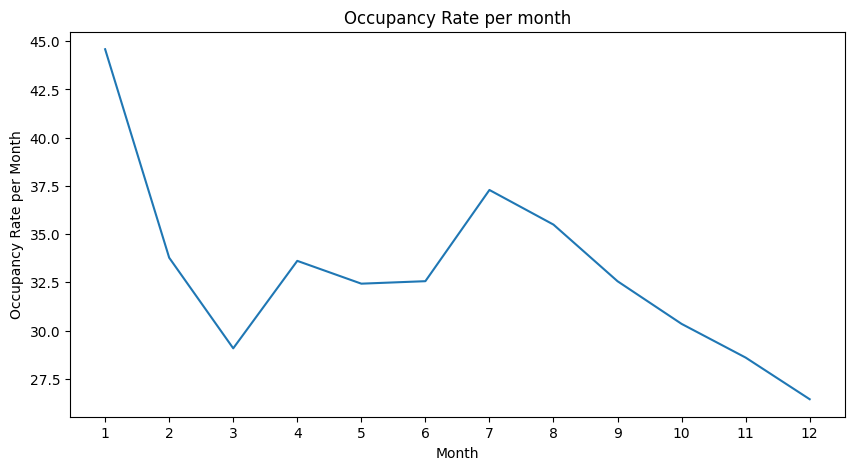

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Occupancy_per_month)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Occupancy Rate per Month')
plt.xlabel('Month')
plt.title('Occupancy Rate per month')


plt.show()

In [ ]:
calendar_df.loc[:,'price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
calendar_df

<ipython-input-13-4e4af2940857>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  calendar_df.loc[:,'price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)


,listing_id,date,available,price,month,year
0,241032,2016-01-04,t,85.0,1,2016
1,241032,2016-01-05,t,85.0,1,2016
2,241032,2016-01-06,f,NaN,1,2016
3,241032,2016-01-07,f,NaN,1,2016
4,241032,2016-01-08,f,NaN,1,2016
...,...,...,...,...,...,...
1393563,10208623,2016-12-27,f,NaN,12,2016
1393564,10208623,2016-12-28,f,NaN,12,2016
1393565,10208623,2016-12-29,f,NaN,12,2016
1393566,10208623,2016-12-30,f,NaN,12,2016


In [ ]:
calendar_df['date'].dtype

dtype('<M8[ns]')

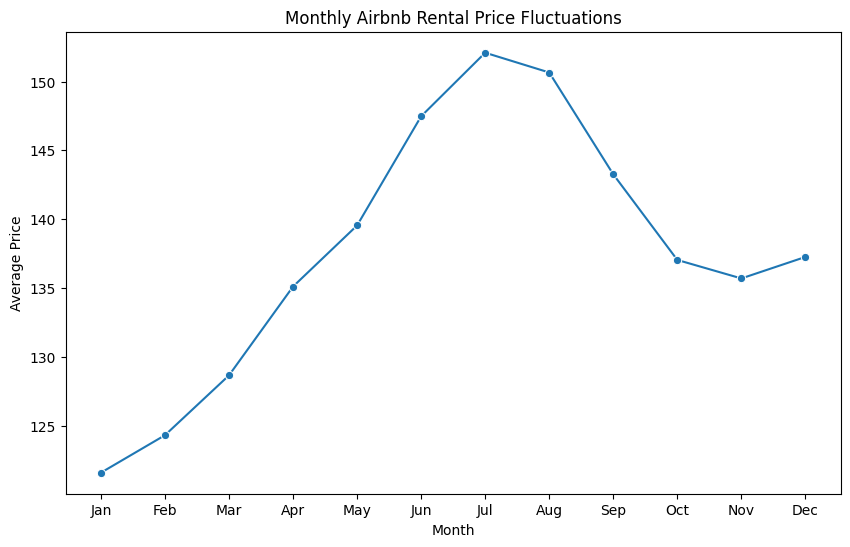

In [ ]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Extract relevant information from the date column (e.g., month, day of the week).
calendar_df['month'] = calendar_df['date'].dt.month
bookings = calendar_df[(calendar_df['available'] == 't')]

# Group the data by month and calculate the average rental price for each month.
monthly_average_prices = bookings.groupby('month')['price'].mean()

# Create a line plot to visualize the monthly rental price fluctuations.
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_average_prices.index, y=monthly_average_prices.values, marker='o')
plt.title('Monthly Airbnb Rental Price Fluctuations')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Display the plot.
plt.show()

#### Answers:
a) What are the peak seasons for Airbnb rentals in Seattle? \\
The peak season would be winter and summer (January and July). \\
b) How do rental prices fluctuate throughout the year?
The rental price is the highest in summer. \\
c) What is the average occupancy rate by season or month? \\
See the picture above.

### Supply Analysis:

a) How many listings are available in each neighborhood?
b) What types of properties are most common (e.g., entire homes vs. private rooms)?
c) Are there enough listings to meet the demand in high-traffic periods?


In [ ]:
#read the listings dataset
# listings_df = pd.read_csv('C:/Users/yuela/OneDrive/Desktop/Job/Airbnb_data/archive/listings.csv')
listings_df = pd.read_csv('airbnb/listings.csv')

In [ ]:
# filter out listings that are not Seattle
host_location_counts = listings_df['host_location'].value_counts()
print(host_location_counts)

seattle_hosts_df = listings_df[listings_df['host_location'] == 'Seattle, Washington, United States']
seattle_hosts_df_count = seattle_hosts_df['host_location'].value_counts()
seattle_hosts_df_count

Seattle, Washington, United States         3259
US                                          246
Spokane, Washington, United States           41
Kent, Washington, United States              34
Los Angeles, California, United States       13
                                           ... 
Port Orchard, Washington, United States       1
Las Vegas, Nevada, United States              1
Bloomington, Indiana, United States           1
Houston, Texas, United States                 1
Arlington, Massachusetts, United States       1
Name: host_location, Length: 120, dtype: int64


Seattle, Washington, United States    3259
Name: host_location, dtype: int64

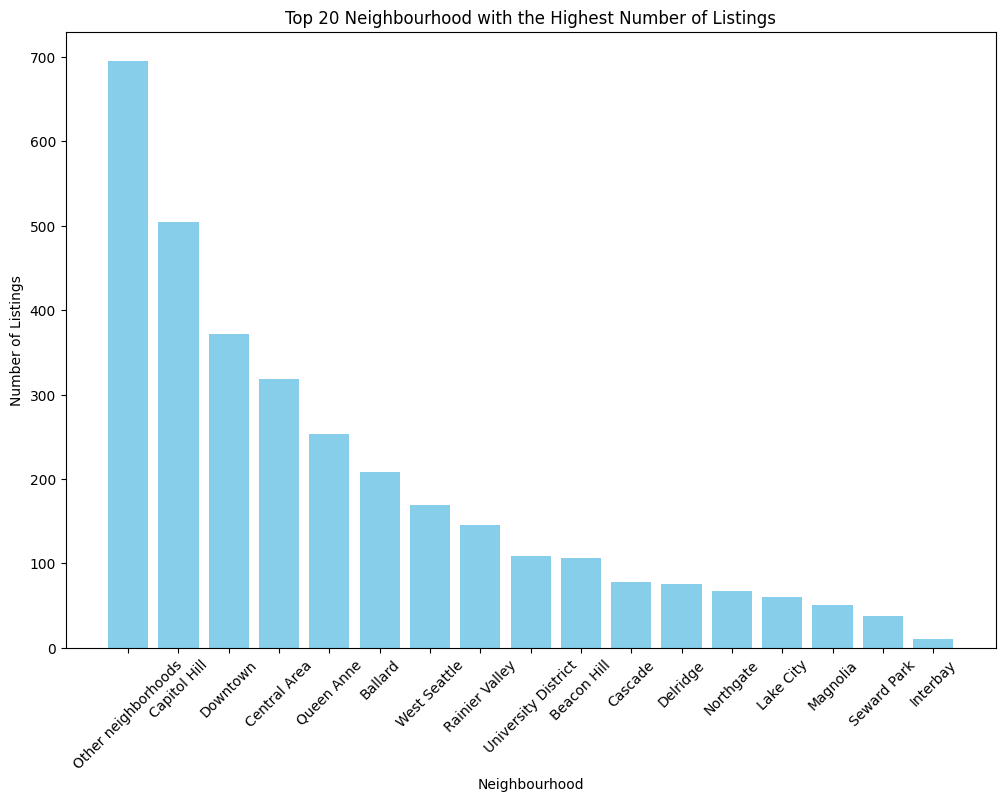

In [ ]:
# Group by zipcode and count listings
listings_per_area = seattle_hosts_df.groupby('neighbourhood_group_cleansed').size()
# listings_per_zipcode.head(100)
listings_per_area.name = 'listings'

sorted_listings = listings_per_area.sort_values(ascending=False)

# Select the top 20
top_20_listings = sorted_listings.head(20)

# Convert to DataFrame for easier plotting
top_20_listings_df = top_20_listings.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top_20_listings_df['neighbourhood_group_cleansed'], top_20_listings_df[listings_per_area.name], color='skyblue')
plt.title('Top 20 Neighbourhood with the Highest Number of Listings')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()

In [ ]:
property_type_counts = seattle_hosts_df['property_type'].value_counts()

print("Property Type Counts:\n", property_type_counts)


Property Type Counts:
 House              1529
Apartment          1413
Townhouse            95
Condominium          73
Loft                 39
Bed & Breakfast      34
Cabin                20
Other                18
Camper/RV            10
Bungalow             10
Boat                  5
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Name: property_type, dtype: int64


#### Answers:
a) How many listings are available in each neighborhood? \\
See picture above (only showing neighborhoods with top 20 listings). \\
b) What types of properties are most common (e.g., entire homes vs. private rooms)? \\
Houses and apartments are most common. \\
c) Are there enough listings to meet the demand in high-traffic periods? \\
Yes. January has the highest occupancy rate, which is 45%.

### Pricing Strategies:

a) What factors affect the pricing of listings?



In [ ]:
total_nan = seattle_hosts_df.isna().sum().sort_values(ascending=False)
percentage_nan = (total_nan / seattle_hosts_df.shape[0]) * 100
table = pd.concat([total_nan, percentage_nan], axis=1, keys=['Total NaN values', 'Percentage of NaN values']).head(60)
table

,Total NaN values,Percentage of NaN values
license,3259,100.000000
square_feet,3171,97.299785
monthly_price,1919,58.883093
security_deposit,1625,49.861921
weekly_price,1488,45.658177
notes,1303,39.981589
cleaning_fee,883,27.094201
neighborhood_overview,821,25.191777
transit,716,21.969929
host_acceptance_rate,634,19.453820


a) I can safely drop variables with more than 50% missing values, i.e., license, square_feet, monthly_price.
b) I choose price as my target variable, therefore, I choose to drop weekly_price.
c) listing_url,scrape_id,last_scraped,experiences_offered,thumbnail_url, medium_url, picture_url, xl_picture_url, host_url,      host_about, host_thumbnail_url are not relevant to our analysis, therefore safe to drop.
d) 'name','summary','space','description', 'notes' all contain textual descriptions about the place. I choose the one with the least missing value. I drop 'name','summary','space', and 'notes'.
e) If 'transit' has value, I set has_transit==1, else ==0. I then drop 'transit'.
f) I drop  'state', 'country', 'country_code'.


In [ ]:
seattle_hosts_df.loc[:,'has_transit'] = np.where(seattle_hosts_df['transit'].notna() & (seattle_hosts_df['transit'] != ''), 1, 0)


<ipython-input-21-04a7ed6bd0ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle_hosts_df.loc[:,'has_transit'] = np.where(seattle_hosts_df['transit'].notna() & (seattle_hosts_df['transit'] != ''), 1, 0)


In [ ]:
seattle_hosts_df.loc[:,'host_since'] = pd.to_datetime(seattle_hosts_df['host_since'])
seattle_hosts_df.loc[:,'last_scraped'] = pd.to_datetime(seattle_hosts_df['last_scraped'])

# Calculate the difference between 'last_review' and 'first_review'
# seattle_hosts_df.loc[:,'host_duration'] = (seattle_hosts_df['last_scraped'] - seattle_hosts_df['host_since']).astype('timedelta64[ns]')

seattle_hosts_df.loc[:,'host_duration'] = ((seattle_hosts_df['last_scraped'] - seattle_hosts_df['host_since'])).astype('timedelta64[ns]').dt.total_seconds()




<ipython-input-23-1483106bfd04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle_hosts_df.loc[:,'host_since'] = pd.to_datetime(seattle_hosts_df['host_since'])
<ipython-input-23-1483106bfd04>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  seattle_hosts_df.loc[:,'host_since'] = pd.to_datetime(seattle_hosts_df['host_since'])
<ipython-input-23-1483106bfd04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [ ]:
print(seattle_hosts_df['host_duration'].dtype)
# print(seattle_final_combined['review_duration'].dtype)

float64


In [ ]:
columns_to_drop = ['license', 'square_feet', 'monthly_price', 'weekly_price','listing_url','scrape_id','last_scraped',
                   'experiences_offered','name','summary','space','notes','transit','state', 'country', 'country_code',
                   'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_about', 'host_thumbnail_url',
                   'host_picture_url','host_has_profile_pic','host_name','host_since']
for column in columns_to_drop:
    if column in seattle_hosts_df.columns:
        seattle_hosts_df.drop(columns=column, inplace=True)


Let us investigate more about the locations.

In [ ]:
seattle_hosts_df[['neighborhood_overview','host_location','host_neighbourhood', 'street', 'neighbourhood','neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'zipcode', 'market', 'smart_location', 'latitude', 'longitude',
       'is_location_exact','jurisdiction_names' ]]

seattle_hosts_df['neighbourhood_group_cleansed'].nunique()
# seattle_hosts_df['zipcode'].nunique()
# seattle_hosts_df[['neighbourhood_group_cleansed', 'zipcode' ]]

17

In [ ]:
# count missing value
columns_location=['neighborhood_overview','host_location','host_neighbourhood', 'street', 'neighbourhood','neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'zipcode', 'market', 'smart_location', 'latitude', 'longitude',
       'is_location_exact','jurisdiction_names']

missing_values_count = seattle_hosts_df[columns_location].isnull().sum()

missing_values_count

neighborhood_overview           821
host_location                     0
host_neighbourhood              246
street                            0
neighbourhood                   342
neighbourhood_cleansed            0
neighbourhood_group_cleansed      0
city                              0
zipcode                           7
market                            0
smart_location                    0
latitude                          0
longitude                         0
is_location_exact                 0
jurisdiction_names                0
dtype: int64

I choose neighbourhood_group_cleansed and zipcode as a proxy for location, and drop the others.


In [ ]:
columns_to_drop = ['neighborhood_overview','host_location','host_neighbourhood', 'street', 'neighbourhood', 'neighbourhood_group_cleansed', 'city',
        'market', 'smart_location', 'latitude', 'longitude',
       'is_location_exact','jurisdiction_names']

seattle_hosts_df = seattle_hosts_df.drop(columns = columns_to_drop)

I then look into availability.

In [ ]:
seattle_hosts_df[['has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365' ]]

,has_availability,availability_30,availability_60,availability_90,availability_365
0,t,14,41,71,346
1,t,13,13,16,291
2,t,1,6,17,220
3,t,0,0,0,143
4,t,30,60,90,365
...,...,...,...,...,...
3810,t,13,43,73,227
3811,t,2,10,13,221
3812,t,11,30,43,287
3814,t,6,26,44,273


In [ ]:
columns_to_drop = ['has_availability', 'availability_60', 'availability_90',
       'availability_365']

seattle_hosts_df = seattle_hosts_df.drop(columns = columns_to_drop)

In [ ]:
# review
seattle_hosts_df[['first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location','reviews_per_month']]

,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month
0,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,4.07
1,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,1.48
2,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,1.15
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,0.89
...,...,...,...,...,...,...,...,...,...
3810,2015-10-01,2015-12-27,92.0,9.0,8.0,10.0,10.0,10.0,1.56
3811,2015-10-01,2015-10-16,100.0,9.0,8.0,10.0,10.0,10.0,0.63
3812,2014-07-08,2015-12-29,96.0,10.0,10.0,10.0,10.0,9.0,4.01
3814,2015-12-18,2015-12-24,100.0,10.0,10.0,10.0,10.0,10.0,2.00


In [ ]:
seattle_hosts_df['has_review'] = seattle_hosts_df['first_review'].notnull()

# Display the DataFrame to verify the results
# seattle_hosts_df[['first_review', 'has_review']]

In [ ]:
seattle_hosts_df.loc[:,'first_review'] = pd.to_datetime(seattle_hosts_df['first_review'])
seattle_hosts_df.loc[:,'last_review'] = pd.to_datetime(seattle_hosts_df['last_review'])

# Calculate the difference between 'last_review' and 'first_review'
# seattle_hosts_df.loc[:,'review_duration'] = (seattle_hosts_df['last_review'] - seattle_hosts_df['first_review']).astype('timedelta64[ns]')

seattle_hosts_df.loc[:,'review_duration'] = (seattle_hosts_df['last_review'] - seattle_hosts_df['first_review']).astype('timedelta64[ns]').dt.total_seconds()



<ipython-input-34-7e1673ae92ca>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  seattle_hosts_df.loc[:,'first_review'] = pd.to_datetime(seattle_hosts_df['first_review'])
<ipython-input-34-7e1673ae92ca>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  seattle_hosts_df.loc[:,'last_review'] = pd.to_datetime(seattle_hosts_df['last_review'])


In [ ]:
columns_to_drop = ['first_review', 'last_review']

seattle_hosts_df = seattle_hosts_df.drop(columns = columns_to_drop)

Look into host_listings_count, host_total_listings_count,calculated_host_listings_count

In [ ]:
seattle_hosts_df[['host_listings_count','host_total_listings_count','calculated_host_listings_count']]

columns_to_drop = ['host_listings_count', 'calculated_host_listings_count']

for column in columns_to_drop:
    if column in seattle_hosts_df.columns:
        seattle_hosts_df = seattle_hosts_df.drop(columns = columns_to_drop)



further delete some irrelevant variables.

In [ ]:
seattle_hosts_df[['host_verifications',
       'host_identity_verified',
       'calendar_updated',  'calendar_last_scraped',
       'requires_license']].head(10)
columns_to_drop = ['host_verifications',
       'host_identity_verified',
       'calendar_updated',  'calendar_last_scraped',
       'requires_license','host_acceptance_rate']
seattle_hosts_df = seattle_hosts_df.drop(columns = columns_to_drop)


In [ ]:
print(seattle_hosts_df.columns)

Index(['id', 'description', 'host_id', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_total_listings_count',
       'neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'reviews_per_month', 'has_transit',
       'host_duration', 'has_review', 'review_duration'],
      dtype='object')


Clean price with $ sign and percentage sign

In [ ]:
def wrangle(X):
    # list of columns that we need to run strip function on
    cols1 = ['host_response_rate']
    cols2 = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
    # iterating over all the columns in the list
    for col in cols1:
        X[col] = X[col].str.strip('%')
    for col in cols2:
        X[col] = X[col].str.strip('$')
    for col in cols2:
        X[col] = X[col].str.replace(',','')


    # change dtype of 'price', security_deposit', 'cleaning_fee', 'extra_people' to float
    for col in cols2:
        X[col] = X[col].astype(float)

    return X

# passing our dataframe as the argument
seattle_hosts_df = wrangle(seattle_hosts_df)

In [ ]:
# for zipcoe i am considering top 17 types and putting the rest under Others

# list of top 17 values
top17 = seattle_hosts_df['zipcode'].value_counts()[:17].index
# if not in top 17 put it under 'Other'
seattle_hosts_df.loc[~seattle_hosts_df['zipcode'].isin(top17), 'zipcode'] = 'Other'

In [ ]:
seattle_hosts_df['security_deposit'] = seattle_hosts_df['security_deposit'].fillna(0)
seattle_hosts_df['cleaning_fee']=seattle_hosts_df['cleaning_fee'].fillna(0)

In [ ]:
# lets have a look where stand with our null values
total_nan = seattle_hosts_df.isna().sum().sort_values(ascending=False)
percentage_nan = (total_nan / seattle_hosts_df.shape[0]) * 100
table = pd.concat([total_nan, percentage_nan], axis=1, keys=['Total NaN values', 'Percentage of NaN values'])
table

,Total NaN values,Percentage of NaN values
review_scores_accuracy,499,15.311445
review_scores_checkin,499,15.311445
review_scores_value,497,15.250077
review_scores_location,497,15.250077
review_scores_cleanliness,494,15.158024
review_scores_communication,493,15.127340
review_scores_rating,489,15.004603
review_duration,475,14.575023
reviews_per_month,475,14.575023
host_response_time,422,12.948757


In [ ]:
seattle_hosts_df[['host_response_time','host_response_rate']]

,host_response_time,host_response_rate
0,within a few hours,96
1,within an hour,98
2,within a few hours,67
3,NaN,NaN
4,within an hour,100
...,...,...
3810,within an hour,100
3811,within a few hours,100
3812,within an hour,100
3814,within an hour,100


Missing response rate meaning there is no conversation between the host and the client.

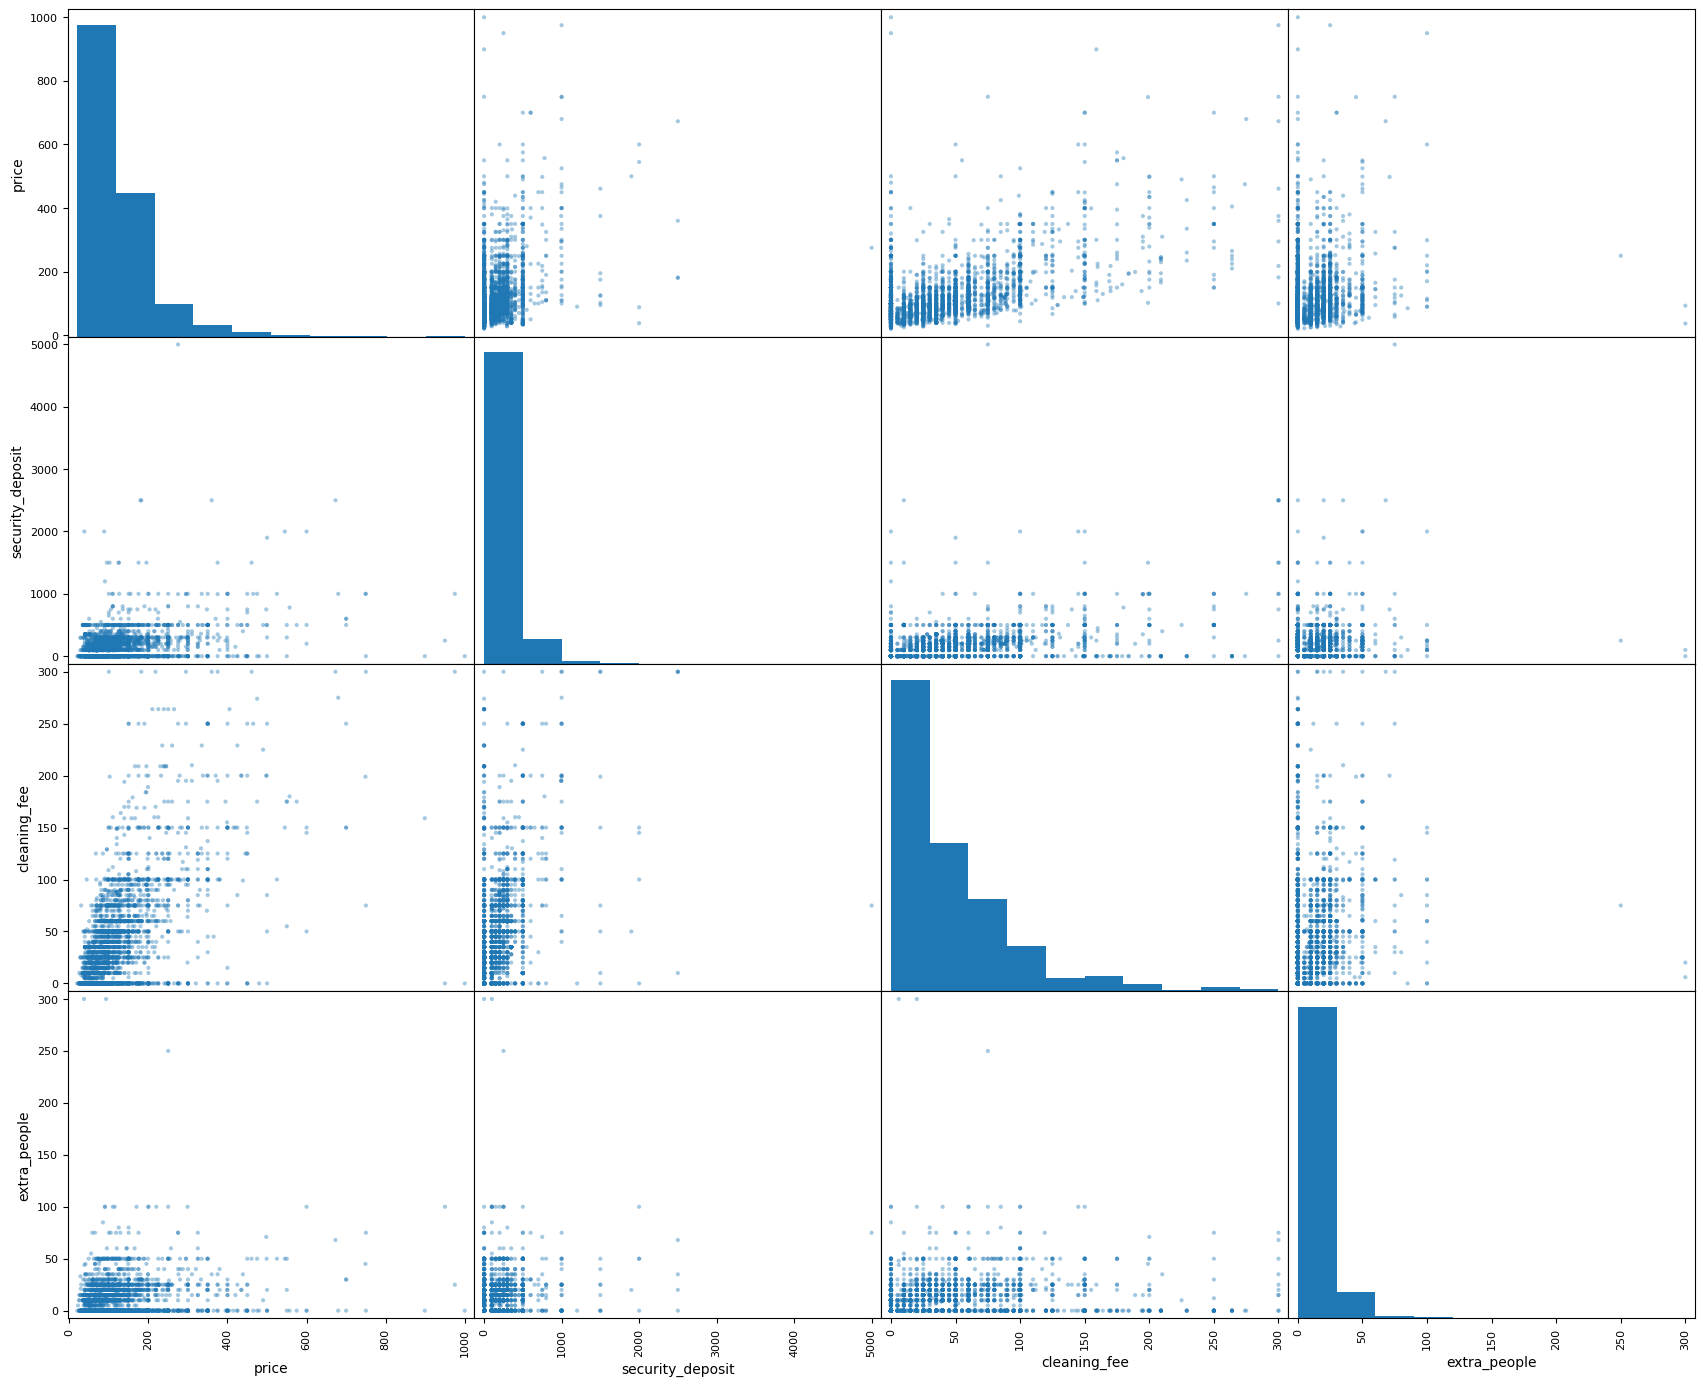

In [ ]:
cols = ['price','security_deposit',
        'cleaning_fee', 'extra_people']


scatter_matrix(seattle_hosts_df[cols], alpha=0.4, figsize=(21,17))
plt.show()

#### Observations 1:
a) price, security_deposit, cleaning_fee, extra_people fee are all highly skewed
b) higher price is correlated with higher cleaning_fee
c) higher security_deposit is correlated with higher cleaning_fee

<Figure size 3200x2400 with 0 Axes>

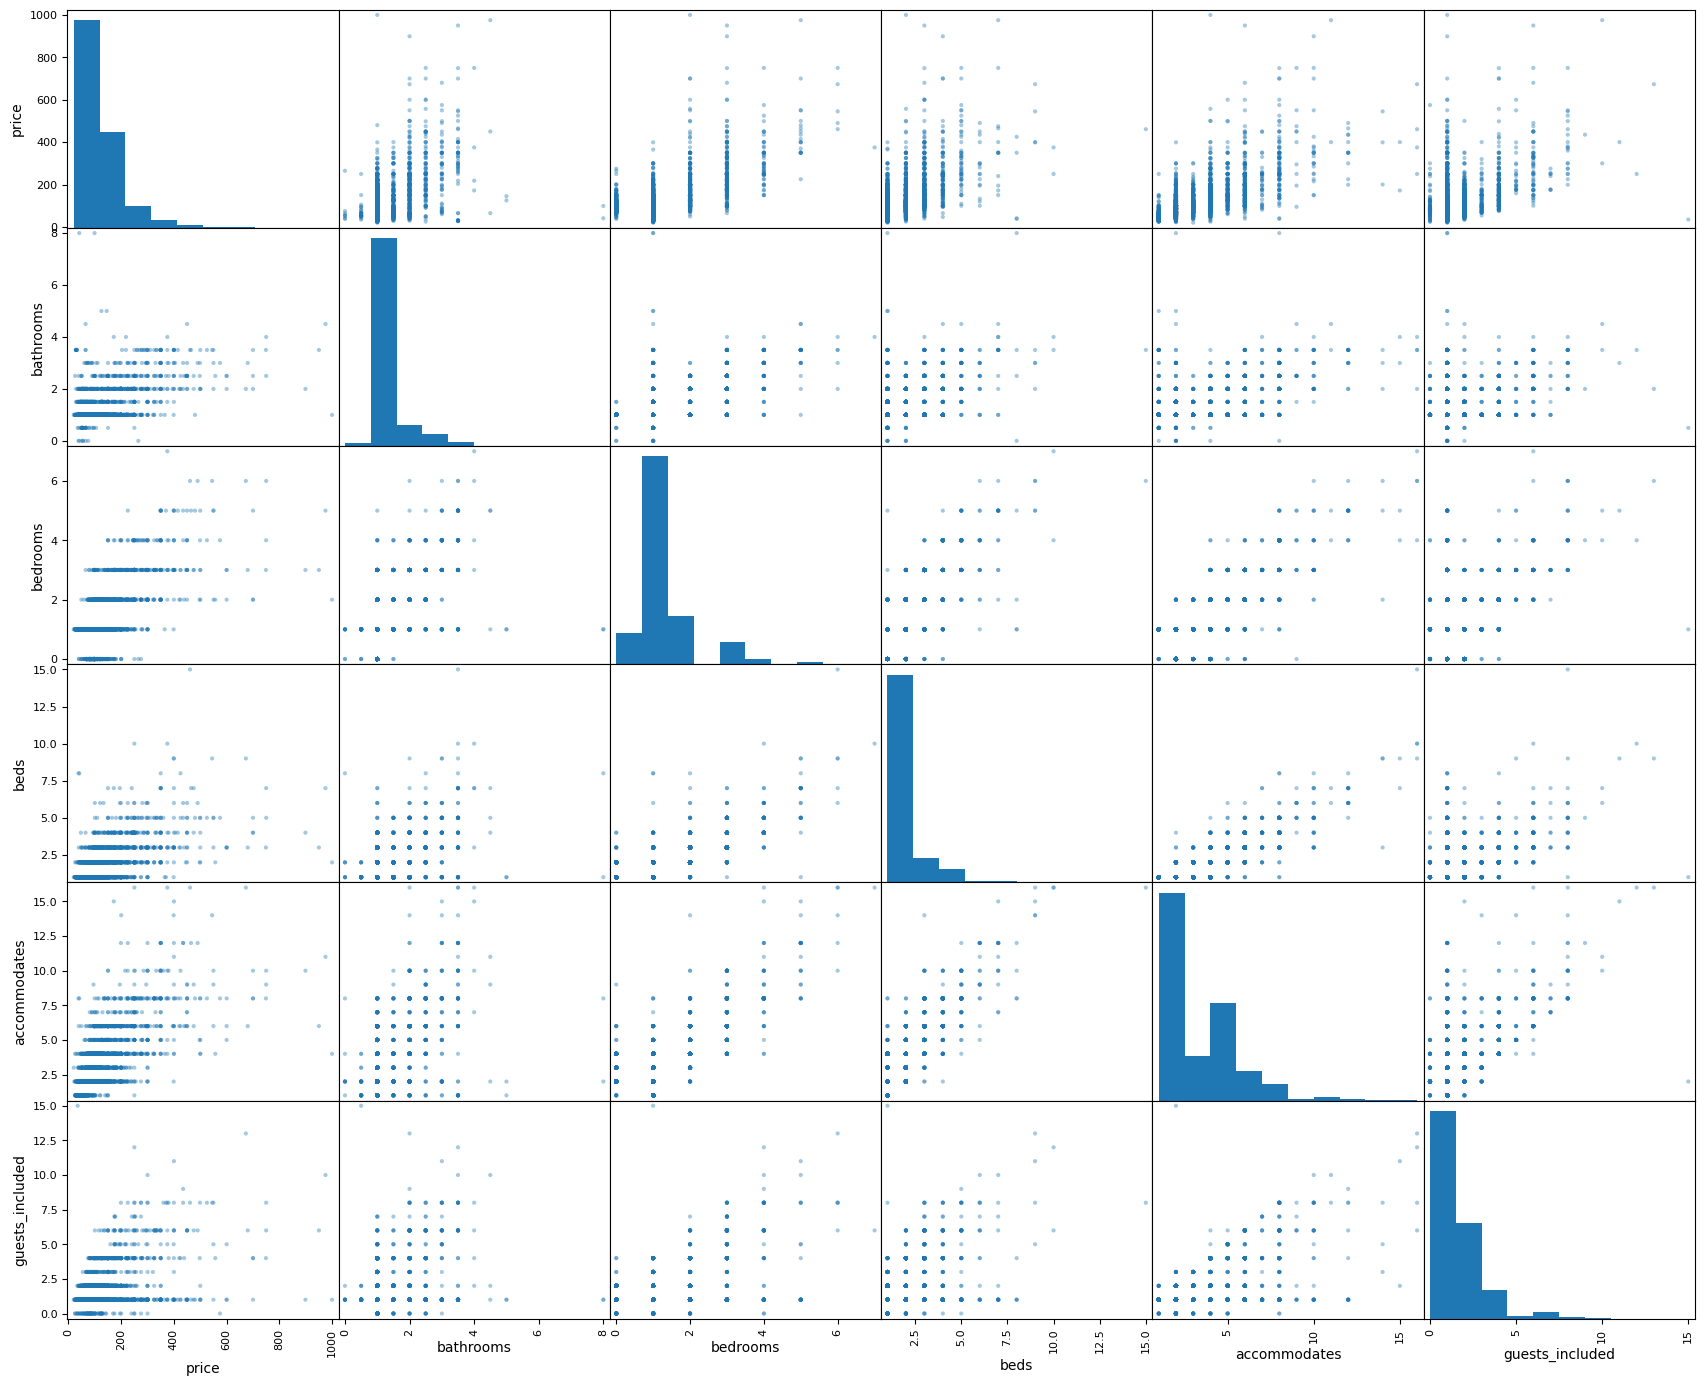

In [ ]:
cols1 = ['price','bathrooms', 'bedrooms',
        'beds', 'accommodates', 'guests_included']

plt.figure(dpi=500, facecolor = '#dadada')

scatter_matrix(seattle_hosts_df[cols1], alpha=0.4, figsize=(21,17))

plt.show()

#### Observations 2:
a) all variables are all somewhat skewed
b) price is positively correlated with all other variables


In [ ]:
cols = ['security_deposit','price', 'bathrooms', 'cleaning_fee', 'bedrooms', 'beds', 'accommodates', 'guests_included', 'extra_people']
def finding_skewness():
    for col in cols:
        print(f'{col} has a skewness of {seattle_hosts_df[col].skew(skipna = True)}')

finding_skewness()

security_deposit has a skewness of 5.668714091851672
price has a skewness of 3.187227297935922
bathrooms has a skewness of 3.121709594417144
cleaning_fee has a skewness of 1.9713796547341917
bedrooms has a skewness of 1.6410643644209437
beds has a skewness of 2.7783509140619893
accommodates has a skewness of 1.886417048903971
guests_included has a skewness of 2.9558184250938653
extra_people has a skewness of 5.246372657464272


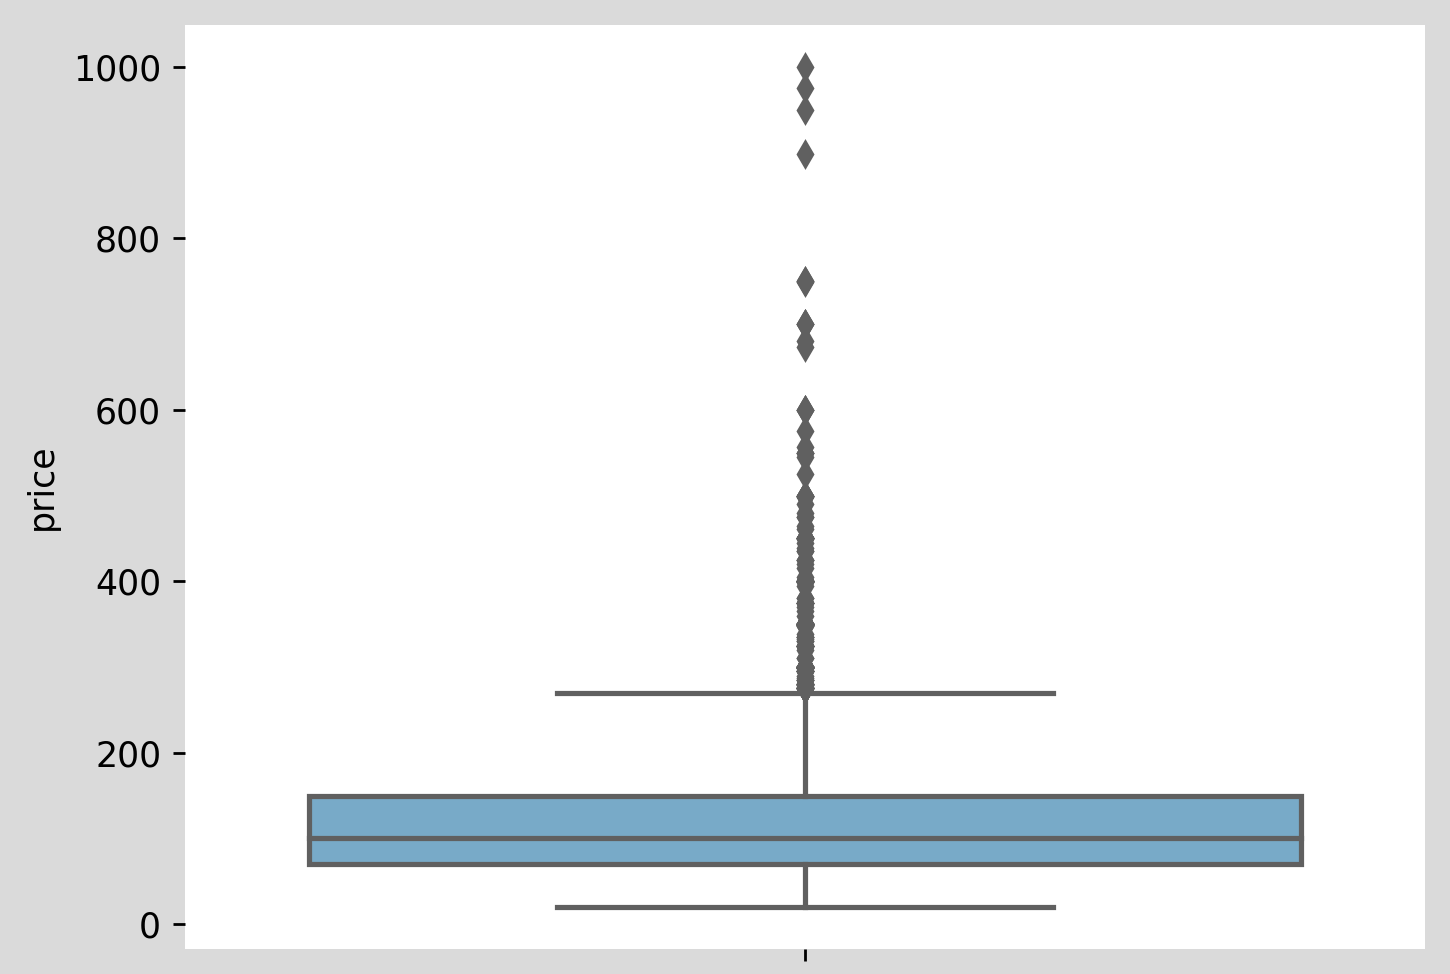

In [ ]:
plt.figure(dpi=250, facecolor='#dadada')

# Corrected boxplot call
sns.boxplot(y='price', data=seattle_hosts_df, palette='Blues')

# Optional: set the y-axis limit if needed
# plt.ylim(0, 5000)

# Remove the spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.show()

I manually checked the price of airbnb that are > 900 dollars. There are three of them. Two of them are now delisted from airbnb. The third one adjusted its price to roughly $500. Remember that the prices in the dataset are not market price. So the host may post a very high or low price to test the market, but the price is not the equilibrium price.

In [ ]:
percentile_99 = seattle_hosts_df['price'].quantile(0.99)
percentile_99

# percentile_01 = seattle_hosts_df['price'].quantile(0.01)
# percentile_01

462.6800000000003

In [ ]:
seattle_hosts_df_filtered = seattle_hosts_df.loc[
    (seattle_hosts_df['price'] >= 31.00) & (seattle_hosts_df['price'] <= 463.00)
]

In [ ]:
cols = ['security_deposit','price', 'bathrooms', 'cleaning_fee', 'bedrooms', 'beds', 'accommodates', 'guests_included', 'extra_people']
def finding_skewness():
    for col in cols:
        print(f'{col} has a skewness of {seattle_hosts_df_filtered[col].skew(skipna = True)}')

finding_skewness()

security_deposit has a skewness of 5.9397792049152685
price has a skewness of 1.8103601389375161
bathrooms has a skewness of 3.329304591141021
cleaning_fee has a skewness of 1.903315389916266
bedrooms has a skewness of 1.4897091338923651
beds has a skewness of 2.799348910848631
accommodates has a skewness of 1.8464627176866812
guests_included has a skewness of 2.8680834812425924
extra_people has a skewness of 5.4222778420211935


In [ ]:
data_types = seattle_hosts_df_filtered.dtypes
print(data_types)

id                                    int64
description                          object
host_id                               int64
host_response_time                   object
host_response_rate                   object
host_is_superhost                    object
host_total_listings_count           float64
neighbourhood_cleansed               object
zipcode                              object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
price                               float64
security_deposit                    float64
cleaning_fee                        float64
guests_included                       int64
extra_people                        float64
minimum_nights                  

Making sure the numerical variables are numerical.

In [ ]:
# cols=['host_response_rate','host_duration','review_duration']
seattle_hosts_df_filtered.loc[:,'host_response_rate'] = seattle_hosts_df_filtered['host_response_rate'].astype(float)

<ipython-input-52-f8ed1c79676c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle_hosts_df_filtered.loc[:,'host_response_rate'] = seattle_hosts_df_filtered['host_response_rate'].astype(float)
<ipython-input-52-f8ed1c79676c>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  seattle_hosts_df_filtered.loc[:,'host_response_rate'] = seattle_hosts_df_filtered['host_response_rate'].astype(float)


In [ ]:
# Encode catagorical variables

response_map = {'within an hour': 0,
                'within a few hours': 1,
                'within a day': 2,
                'a few days or more':3 ,
                np.nan:4}
seattle_hosts_df_filtered.loc[:,'response_map'] = seattle_hosts_df_filtered['host_response_time'].map(response_map)

seattle_hosts_df_filtered = seattle_hosts_df_filtered.drop('host_response_time', axis=1)



<ipython-input-53-a4142ca72445>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seattle_hosts_df_filtered.loc[:,'response_map'] = seattle_hosts_df_filtered['host_response_time'].map(response_map)


In [ ]:

# Replace NaN with a default value 'f' for False using .fillna
seattle_hosts_df_filtered['host_is_superhost'].fillna('f',inplace = True)

one_hot = pd.get_dummies(seattle_hosts_df_filtered['host_is_superhost'])

# concatenate the one-hot encoding with the original dataframe
seattle_hosts_df_filtered1 = pd.concat([seattle_hosts_df_filtered, one_hot], axis=1)

# drop the original 'color' column
seattle_hosts_df_filtered1 = seattle_hosts_df_filtered1.drop('host_is_superhost', axis=1)


variable_list = seattle_hosts_df_filtered1.columns.tolist()
print(variable_list)

['id', 'description', 'host_id', 'host_response_rate', 'host_total_listings_count', 'neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month', 'has_transit', 'host_duration', 'has_review', 'review_duration', 'response_map', 'f', 't']


In [ ]:
seattle_hosts_df_filtered1.head(3)

,id,description,host_id,host_response_rate,host_total_listings_count,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,...,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,has_transit,host_duration,has_review,review_duration,response_map,f,t
0,241032,Make your self at home in this charming one-be...,956883,96.0,3.0,West Queen Anne,98119,Apartment,Entire home/apt,4,...,f,f,4.07,0,138844800.0,True,131587200.0,1,1,0
1,953595,Chemically sensitive? We've removed the irrita...,5177328,98.0,6.0,West Queen Anne,98119,Apartment,Entire home/apt,4,...,t,t,1.48,1,90460800.0,True,74476800.0,0,0,1
3,7421966,A charming apartment that sits atop Queen Anne...,9851441,NaN,1.0,West Queen Anne,98119,Apartment,Entire home/apt,3,...,f,f,NaN,0,68169600.0,False,NaN,4,1,0


In [ ]:
# seattle_hosts_df['host_is_superhost']
# seattle_hosts_df['host_is_superhost'] = seattle_hosts_df['host_is_superhost'].replace([np.inf, -np.inf], np.nan)

seattle_hosts_df_filtered['host_is_superhost'].fillna('f', inplace=True)
seattle_hosts_df_filtered['host_is_superhost'] = seattle_hosts_df_filtered['host_is_superhost'].map({'f': 0, 't': 1})



In [ ]:
seattle_hosts_df['host_is_superhost'].unique()

array(['f', 't'], dtype=object)

In [ ]:
data_type = seattle_hosts_df_filtered1.dtypes
print(f'Data Type: {data_type}')

Data Type: id                                    int64
description                          object
host_id                               int64
host_response_rate                  float64
host_total_listings_count           float64
neighbourhood_cleansed               object
zipcode                              object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
price                               float64
security_deposit                    float64
cleaning_fee                        float64
guests_included                       int64
extra_people                        float64
minimum_nights                        int64
maximum_nights                        int64
availability_30      

Dealing with 'neighbourhood_cleansed': label encoding

In [ ]:
one_hot = pd.get_dummies(seattle_hosts_df_filtered1['neighbourhood_cleansed'])

# concatenate the one-hot encoding with the original dataframe
seattle_hosts_df_filtered2 = pd.concat([seattle_hosts_df_filtered1, one_hot], axis=1)

# drop the original 'color' column
seattle_hosts_df_filtered2 = seattle_hosts_df_filtered2.drop('neighbourhood_cleansed', axis=1)


In [ ]:
# Drop non-numeric columns, including 'description'
numeric_columns = seattle_hosts_df_filtered2.select_dtypes(include=[np.number])
numeric_columns = numeric_columns.drop(columns=['id','host_id'])

seattle_corr = numeric_columns.corr()

seattle_corr.price.sort_values(ascending=False)

price                  1.000000
accommodates           0.675656
bedrooms               0.636291
beds                   0.593849
cleaning_fee           0.580319
                         ...   
North Delridge        -0.060153
availability_30       -0.065705
University District   -0.069362
number_of_reviews     -0.129534
reviews_per_month     -0.220504
Name: price, Length: 116, dtype: float64

a) accommodates, bedrooms, beds, cleaning_fee, bathrooms, guests_included are highly correlated, I only keep accommodates.
b) number_of_reviews  and reviews_per_month are highly correlated, I delete   number_of_reviews.    
c) review_scores_rating, review_scores_cleanliness, host_total_listings_count, review_scores_checkin, review_scores_communication, review_scores_accuracy are highly correlated, I only keep review_scores_rating.

In [ ]:
columns_to_drop = [ 'bedrooms', 'beds', 'cleaning_fee', 'bathrooms', 'guests_included','number_of_reviews',
                   'review_scores_cleanliness', 'host_total_listings_count','review_scores_checkin',
                   'review_scores_communication', 'review_scores_accuracy','review_scores_value','review_duration',
                   'number_of_reviews']
for column in columns_to_drop:
    if column in seattle_hosts_df_filtered2.columns:
         seattle_hosts_df_filtered2.drop(column, axis=1, inplace=True)

In [ ]:
num_attribs = seattle_hosts_df_filtered2.select_dtypes(exclude='object')
num_attribs.columns
print(num_attribs.columns)

### Extracting information from amenities

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# import nltk
# from nltk import sent_tokenize, word_tokenize
# import re
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [ ]:
seattle_hosts_df_filtered2['amenities']

In [ ]:
def clean_amenities(amenity):
    # Remove curly braces, double quotes, and any characters that are not letters, digits, spaces, or underscores
    cleaned_amenity = amenity.replace('{', '').replace('}', '').replace('"', '').lower()
    return cleaned_amenity

# Apply the cleaning function to the 'amenities' column
seattle_hosts_df_filtered2['amenities'] = seattle_hosts_df_filtered2['amenities'].apply(clean_amenities)
seattle_hosts_df_filtered2['amenities']

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Extracting valuable information from amenities
# preprocessing
lemmatizer = WordNetLemmatizer()
corpus_am = []

seattle_hosts_df_filtered2.reset_index(drop=True, inplace=True)

for i in range(len(seattle_hosts_df_filtered2)):

# for i in range(0,1):
    review = seattle_hosts_df_filtered2['amenities'][i]
    review = review.split(',')
    review_list = [review.strip() for review in review]
    review_list = [lemmatizer.lemmatize(word) for word in review_list if word not in stopwords.words('english') ]

    review_list = ' '.join(review_list)
    corpus_am.append(review_list)

print(corpus_am)

['tv cable tv internet wireless internet air conditioning kitchen heating family/kid friendly washer dryer', 'tv internet wireless internet kitchen free parking on premises buzzer/wireless intercom heating family/kid friendly washer dryer smoke detector carbon monoxide detector first aid kit safety card fire extinguisher essential', 'internet wireless internet kitchen indoor fireplace heating family/kid friendly washer dryer smoke detector carbon monoxide detector safety card fire extinguisher essential shampoo', 'tv cable tv internet wireless internet kitchen heating family/kid friendly smoke detector carbon monoxide detector first aid kit fire extinguisher essential shampoo', 'wireless internet free parking on premises heating smoke detector essential shampoo', 'wireless internet free parking on premises heating smoke detector first aid kit essential shampoo', 'wireless internet pets live on this property dog(s) heating family/kid friendly essential shampoo', 'tv cable tv internet wi

In [ ]:
#passing the list of amenities that i am interested in
vect = CountVectorizer(analyzer='word',
                       ngram_range=(1, 2),
                       vocabulary=['cable tv','wireless internet', 'kitchen','heating', 'dryer', 'washer',
                                     'free parking on premises','smoke detector','shampoo','essentials',
                                       'carbon monoxide detector','fire extinguisher','family kid friendly',
                                        'first aid kit','air conditioning','buzzer wireless intercom',
                                   'safety card', 'pets allowed','pets live on this property','dogs','cats',
                                   'hot tub','indoor fireplace','breakfast','24 hour check in','hangers',
                                   'hair dryer','iron','laptop friendly workspace','elevator in building',
                                   'suitable for events','wheelchair accessible','gym','pool'])

# fit corpus_am
para_dtm = vect.fit(corpus_am)

# examine the fitted vocabulary
vect.get_feature_names_out()

array(['cable tv', 'wireless internet', 'kitchen', 'heating', 'dryer',
       'washer', 'free parking on premises', 'smoke detector', 'shampoo',
       'essentials', 'carbon monoxide detector', 'fire extinguisher',
       'family kid friendly', 'first aid kit', 'air conditioning',
       'buzzer wireless intercom', 'safety card', 'pets allowed',
       'pets live on this property', 'dogs', 'cats', 'hot tub',
       'indoor fireplace', 'breakfast', '24 hour check in', 'hangers',
       'hair dryer', 'iron', 'laptop friendly workspace',
       'elevator in building', 'suitable for events',
       'wheelchair accessible', 'gym', 'pool'], dtype=object)

In [ ]:
seattle_hosts_df_filtered2['property_type'].unique()

array(['Apartment', 'House', 'Cabin', 'Camper/RV', 'Bungalow',
       'Townhouse', 'Condominium', 'Loft', 'Boat', 'Bed & Breakfast',
       'Other', 'Dorm', 'Treehouse', 'Chalet', 'Tent', nan], dtype=object)

In [ ]:
amenities_dtm = vect.transform(corpus_am).toarray()

In [ ]:
amenities_dtm = pd.DataFrame(amenities_dtm, columns=vect.get_feature_names_out())
amenities_dtm

,cable tv,wireless internet,kitchen,heating,dryer,washer,free parking on premises,smoke detector,shampoo,essentials,...,24 hour check in,hangers,hair dryer,iron,laptop friendly workspace,elevator in building,suitable for events,wheelchair accessible,gym,pool
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,1,1,1,1,2,1,0,1,1,0,...,0,0,1,1,0,0,0,0,0,0
3190,1,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3191,0,1,1,1,2,1,0,1,1,0,...,0,0,1,1,0,0,0,0,0,0
3192,1,1,1,1,1,0,0,1,1,0,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
amenities_dtm = amenities_dtm.rename(columns=lambda x: x.replace(" ","_").replace('-','_'))

amenities_dtm

,cable_tv,wireless_internet,kitchen,heating,dryer,washer,free_parking_on_premises,smoke_detector,shampoo,essentials,...,24_hour_check_in,hangers,hair_dryer,iron,laptop_friendly_workspace,elevator_in_building,suitable_for_events,wheelchair_accessible,gym,pool
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,1,1,1,1,2,1,0,1,1,0,...,0,0,1,1,0,0,0,0,0,0
3190,1,1,1,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3191,0,1,1,1,2,1,0,1,1,0,...,0,0,1,1,0,0,0,0,0,0
3192,1,1,1,1,1,0,0,1,1,0,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
# we are setting left_index and right_index=True to be able to merge two dataframes that have no columns in common
seattle_final = pd.merge(seattle_hosts_df_filtered2, amenities_dtm, left_index=True, right_index=True)
seattle_final['host_response_rate'] = seattle_final['host_response_rate'].astype(float)

columns_to_drop = ['id','host_id','description','zipcode','require_guest_profile_picture','require_guest_phone_verification',
                  'amenities']

seattle_final = seattle_final.drop(columns = columns_to_drop)
seattle_final.head()


,host_response_rate,property_type,room_type,accommodates,bed_type,price,security_deposit,extra_people,minimum_nights,maximum_nights,...,24_hour_check_in,hangers,hair_dryer,iron,laptop_friendly_workspace,elevator_in_building,suitable_for_events,wheelchair_accessible,gym,pool
0,96.0,Apartment,Entire home/apt,4,Real Bed,85.0,0.0,5.0,1,365,...,0,0,0,0,0,0,0,0,0,0
1,98.0,Apartment,Entire home/apt,4,Real Bed,150.0,100.0,0.0,2,90,...,0,0,0,0,0,0,0,0,0,0
2,NaN,Apartment,Entire home/apt,3,Real Bed,100.0,0.0,0.0,1,1125,...,0,0,0,0,0,0,0,0,0,0
3,100.0,House,Entire home/apt,6,Real Bed,450.0,700.0,15.0,1,1125,...,0,0,0,0,0,0,0,0,0,0
4,NaN,House,Private room,2,Real Bed,120.0,0.0,30.0,1,6,...,0,0,0,0,0,0,0,0,0,0


### Encoding and Imputing:
a) I will be using simple imputer with median for numerical attributes as there are outliers
b) I will be using simple imputer with 'most_frequent' for categorical attributes



In [ ]:
seattle_final['cancellation_policy'].unique()

array(['moderate', 'strict', 'flexible'], dtype=object)

In [ ]:
response_map = {'flexible': 0,
                'moderate': 1,
                'strict': 2}
seattle_final.loc[:,'cancellation_policy'] = seattle_hosts_df_filtered['cancellation_policy'].map(response_map)

seattle_final = seattle_final.drop('cancellation_policy', axis=1)


<ipython-input-133-a0d598e42598>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  seattle_final.loc[:,'cancellation_policy'] = seattle_hosts_df_filtered['cancellation_policy'].map(response_map)


In [ ]:
# Counting missing values
missing_values_count = seattle_final.isna().sum()
print("Missing values count per column:\n", missing_values_count)

Missing values count per column:
 host_response_rate       411
property_type              1
room_type                  0
accommodates               0
bed_type                   0
                        ... 
elevator_in_building       0
suitable_for_events        0
wheelchair_accessible      0
gym                        0
pool                       0
Length: 142, dtype: int64


In [ ]:
seattle_final['host_response_rate'].describe()
# seattle_final['host_response_rate'].skew()

mean_host_response_rate = seattle_final['host_response_rate'].mean()

# Replace NaN values in column 'A' with the mean
seattle_final['host_response_rate'].fillna(mean_host_response_rate, inplace=True)

In [ ]:
# most frequent
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

# Assuming df is your DataFrame and 'your_column' is the column you want to transform
seattle_final['property_type'] = imputer.fit_transform(seattle_final[['property_type']]).ravel()


In [ ]:
imputer.fit_transform(seattle_final[['property_type']]).ravel()

array(['Apartment', 'Apartment', 'Apartment', ..., 'Apartment',
       'Apartment', 'Apartment'], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
seattle_final_encoded = encoder.fit_transform(seattle_final[['property_type', 'room_type','bed_type','instant_bookable']])

# Convert the array back to a DataFrame with appropriate column names
seattle_final_encoded = pd.DataFrame(seattle_final_encoded,
                                     columns=encoder.get_feature_names_out(['property_type', 'room_type','bed_type','instant_bookable']))


seattle_final_reset = seattle_final.reset_index(drop=True)
seattle_final_encoded_reset = seattle_final_encoded.reset_index(drop=True)


# # Join the one-hot encoded DataFrame with the original DataFrame
seattle_final_combined = pd.concat([seattle_final_reset, seattle_final_encoded_reset], axis=1)

seattle_final_combined.drop(['property_type', 'room_type', 'bed_type', 'instant_bookable'], axis=1, inplace=True)


In [ ]:
missing_values = seattle_final_combined.isnull().sum()

# Filter out columns that have missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Display the columns with their count of missing values
print(columns_with_missing_values)

review_scores_rating      480
review_scores_location    486
reviews_per_month         466
dtype: int64


In [ ]:
# Create a SimpleImputer object with the mean strategy
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Apply the imputer to your data
seattle_final_mean_imputed = imputer_mean.fit_transform(seattle_final_combined)

In [ ]:
seattle_final_combined = seattle_final_combined.fillna(seattle_final_combined.mean())

#### Save file to Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/Airbnb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# save the dataset
import pickle

with open('seattle_airbnb.pickle', 'wb') as output:
    pickle.dump(seattle_final_combined, output)

In [ ]:
os.chdir('/content/drive/My Drive/Airbnb')
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)

/content/drive/My Drive/Airbnb


In [ ]:
import pickle
with open('seattle_airbnb.pickle', 'rb') as data:
    seattle_final_combined = pickle.load(data)

In [ ]:
average_price = sum(seattle_final_combined['price']) / len(seattle_final_combined['price'])
print(f"The average booking price is: ${average_price:.2f}")

The average booking price is: $120.11


In [ ]:
from sklearn.model_selection import train_test_split
X = seattle_final_combined.drop('price', axis=1)  # Drop the 'price' column to get the features
y = seattle_final_combined['price']  # Assign the 'price' column as the target variable
# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# # scale input variables
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # Fit the scaler to the training data and transform the training data
# X = scaler.fit_transform(X)

# # Transform the test data
# X_test = scaler.transform(X_test)

## Baseline Model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Baseline MAE:', mean_absolute_error(y_train, [y_train.mean()]*len(y_train)))
print('Baseline MSE:', mean_squared_error(y_train, [y_train.mean()]*len(y_train)))

Baseline MAE: 51.9233199705719
Baseline MSE: 5160.939001546477


### Model Selection

#### Model 1 : Linear Regression

##### Cross Vlidation of Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 2111.1319414199756
Mean Absolute Error (MAE): 32.650078232310385


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
# Perform cross-validation
scores = cross_val_score(model1, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')

# The 'scores' will hold 5 negative mean squared error scores, one for each fold
# To get the mean squared error, we take the absolute value
mae_scores = -scores

print("MAE scores for each fold:", mae_scores)
print("Average MAE:", np.mean(mae_scores))

MAE scores for each fold: [34.4436756  32.27127924 34.92052797]
Average MAE: 33.878494272732524


#### Model 2 : Random Forest

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Create and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 1953.7436605658388
Mean Absolute Error (MAE): 29.816745717265007


##### Hyperparameter Tuning

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_regressor.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(80, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='neg_mean_absolute_error',n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [80, 90, 100, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [ ]:
best_model = rf_random.best_estimator_
predictions = best_model.predict(X_test)

# Calculate MSE and MAE
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 1986.847846608511
Mean Absolute Error: 29.9626022808801


##### Feature Importance

In [ ]:
# rf_regressor.feature_importances_

import pandas as pd

features = pd.Series(rf_regressor.feature_importances_, index=X_train.columns)
features.sort_values(ascending=False, inplace=True)
print(features.head(10))

accommodates                 0.411981
room_type_Entire home/apt    0.097885
reviews_per_month            0.053666
host_duration                0.047213
security_deposit             0.031585
response_map                 0.027248
extra_people                 0.023674
availability_30              0.023502
review_scores_rating         0.020847
minimum_nights               0.019509
dtype: float64


#### Model 3 : xgboost

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

# Create and train the XGBoost Regressor
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 1938.111905619732
Mean Absolute Error (MAE): 30.008017268494097
